## COVID Impact Analysis

In [1]:
import os, re, sys, utilities
spark_home = os.environ.get('SPARK_HOME', None)

In [2]:
code = utilities.getSparkContext()
exec(code)

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.3.2.3.1.5.22-6
      /_/

Using Python version 3.6.8 (default, Dec 30 2018 01:22:34)
SparkSession available as 'spark'.


In [3]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, HiveContext

In [4]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
import time
#import datetime
import math
import scipy

In [5]:
from pyspark.sql.functions import col, udf, countDistinct, isnan, when, count, to_date, from_unixtime, unix_timestamp, min, max, row_number
from pyspark.sql.window import Window
from pyspark.sql.types import Row
from pyspark.sql.functions import year, month, dayofmonth, hour

In [6]:
from pyspark.sql.types import DoubleType, FloatType, BooleanType, LongType, \
IntegerType, TimestampType, StringType, StructType, StructField, ArrayType

In [7]:
from pyspark.sql.functions import lit

In [8]:
import matplotlib.dates as mdates

### Average trips per vehicle per month calculation - data from Trip Summary

In [9]:
#	Avg Trips/VIN/Month		
#Month	2019	2020	% change YoY
#2	102.7506106	105.7965668	2.964416612
#3	110.8856751	95.9610399	-13.45947991
#4	114.4742336	66.92108007	-41.54048647
#5	122.0231965	85.04307502	-30.30581277


In [10]:
# intialise data of lists. 
data = {'Month':['2', '3', '4', '5'], 'trips_2019':[102.7506106, 110.8856751, 114.4742336, 122.0231965], 'trips_2020':[105.7965668, 95.9610399, 66.92108007, 85.04307502], 'YoY_pct_change':[2.964416612, -13.45947991, -41.54048647, -30.30581277]} 
  
# Create DataFrame 
df = pd.DataFrame(data) 

In [11]:
df 

Month  trips_2019  trips_2020  YoY_pct_change
0     2  102.750611  105.796567        2.964417
1     3  110.885675   95.961040      -13.459480
2     4  114.474234   66.921080      -41.540486
3     5  122.023196   85.043075      -30.305813

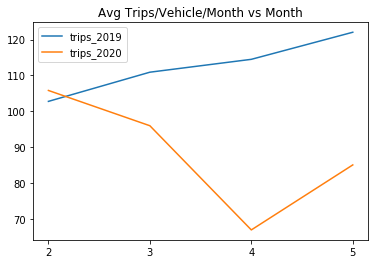

In [12]:
#plot avg trips and yoy change
plt.plot(df.Month, df.trips_2019)
plt.plot(df.Month, df.trips_2020)

# control x and y limits
#plt.ylim(0, None)
#plt.xlim([datetime.date(2020, 1, 1), datetime.date(2020, 6, 11)])

# axis lables
#plt.xlabel('x - axis')
#plt.ylabel('y - axis')
# Set a title of the current axes.
plt.title('Avg Trips/Vehicle/Month vs Month')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

Text(0.5, 1.0, 'YoY % Change')

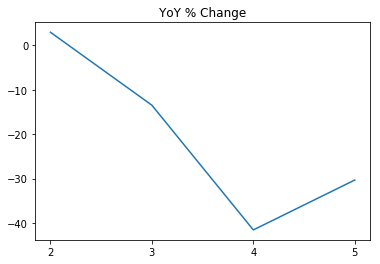

In [13]:
#plot total YoY change
plt.plot(df.Month, df.YoY_pct_change)

# control x and y limits
#plt.ylim(0, None)
#plt.xlim([datetime.date(2020, 1, 1), datetime.date(2020, 6, 11)])

plt.title('YoY % Change')

In [14]:
#avg for year 2019?

### Read .csv file list of vehicles that moved into BIN4 after March 2020 due to bad R2

In [57]:
# read csv file with list of vins that moved to bin 4 since march 2020
bin4_vins = spark.read.format("csv").option("header", "true").load('hdfs://hdp2cluster/user/lguerra5/bin4_lowr2_pull_080520.csv')

In [58]:
bin4_vins = bin4_vins.withColumn("orig_bin", lit(4))

In [59]:
bin4_vins.show(5)

+-----------------+-----------+---------------+-------------------+------------+---------------+-------------------+------------+------------------+----------------+------------+---------------+------------------------------+------------------------------+--------------------+----------+--------+
|              VIN|NUM_SAMPLES|OIL_MODEL_SLOPE|OIL_MODEL_INTERCEPT|OIL_MODEL_R2|ODO_MODEL_SLOPE|ODO_MODEL_INTERCEPT|ODO_MODEL_R2|PRED_OIL_ZERO_DATE|PRED_OIL_ZERO_KM|LAST_UPDATED|PRED_DATE_LIMIT|PRED_ODO_LIMIT_IF_UNDER_MAX_KM|PRED_ODO_LIMIT_IF_ABOVE_MAX_KM|MAX_OIL_CHANGE_CYCLE|CREATED_ON|orig_bin|
+-----------------+-----------+---------------+-------------------+------------+---------------+-------------------+------------+------------------+----------------+------------+---------------+------------------------------+------------------------------+--------------------+----------+--------+
|1FA6P8CF0J5101358|       1500|   -2.724668642|       -151.0732113|       0.314|    0.017417244|       -12

In [60]:
orig_bin4_count = bin4_vins.count()
print(orig_bin4_count)

224273


In [61]:
#drop unnecessary columns - create subset for joining
#columns_to_drop = ['Last_', 'vin2']
#bin4_sub = bin4_vins.drop(*columns_to_drop)
bin4_sub = bin4_vins.select('VIN','OIL_MODEL_R2','NUM_SAMPLES','orig_bin')

In [62]:
#bin4_sub = bin4_sub.withColumnRenamed("OIL_MODEL_R2", "orig_r2").withColumnRenamed("NUM_SAMPLES", "orig_n")
bin4_sub = bin4_sub.withColumnRenamed("OIL_MODEL_R2", "orig_r2").withColumnRenamed("NUM_SAMPLES", "orig_n").withColumnRenamed("VIN", "vin")

In [63]:
#bin4_sub = bin4_vins

In [64]:
#check for empty values of vin field (all empty values are just empty string and not null/nan)
bin4_sub.filter((bin4_sub["vin"] == "") | bin4_sub["vin"].isNull() | isnan(bin4_sub["vin"])).count()

0

In [65]:
bin4_sub.filter((bin4_sub["orig_r2"] == "") | bin4_sub["orig_r2"].isNull() | isnan(bin4_sub["orig_r2"])).count()

0

In [66]:
bin4_sub.show(5)

+-----------------+-------+------+--------+
|              vin|orig_r2|orig_n|orig_bin|
+-----------------+-------+------+--------+
|1FA6P8CF0J5101358|  0.314|  1500|       4|
|1FA6P8CF0J5103322| -2.073|   630|       4|
|1FA6P8CF0J5105524| -3.744|  1500|       4|
|1FA6P8CF0J5106317| -0.034|  1500|       4|
|1FA6P8CF0J5106933| -0.364|  1021|       4|
+-----------------+-------+------+--------+
only showing top 5 rows



### How many vehicles in bin 4 last week still in bin4 this week?

In [67]:
# read csv file with list of vins that moved to bin 4 since march 2020
bin4_vins_update = spark.read.format("csv").option("header", "true").load('hdfs://hdp2cluster/user/lguerra5/bin4_lowr2_pull_081220.csv')

In [68]:
update_bin4_count = bin4_vins_update.count()
print(update_bin4_count)

218863


In [69]:
# affected vin count difference - number of vins that were in bin 4 due to low r2 last week that are no longer in this catagory this week
orig_bin4_count - update_bin4_count

5410

In [70]:
5410/orig_bin4_count

0.02412238655567099

In [27]:
#bin4_vins_update = bin4_vins_update.withColumnRenamed("OIL_MODEL_R2", "orig_r2").withColumnRenamed("NUM_SAMPLES", "orig_n").withColumnRenamed("VIN", "vin")

In [71]:
bin4_vins_update.show(5)

+-----------------+-----------+---------------+-------------------+------------+---------------+-------------------+------------+------------------+----------------+------------+---------------+------------------------------+------------------------------+--------------------+----------+
|              VIN|NUM_SAMPLES|OIL_MODEL_SLOPE|OIL_MODEL_INTERCEPT|OIL_MODEL_R2|ODO_MODEL_SLOPE|ODO_MODEL_INTERCEPT|ODO_MODEL_R2|PRED_OIL_ZERO_DATE|PRED_OIL_ZERO_KM|LAST_UPDATED|PRED_DATE_LIMIT|PRED_ODO_LIMIT_IF_UNDER_MAX_KM|PRED_ODO_LIMIT_IF_ABOVE_MAX_KM|MAX_OIL_CHANGE_CYCLE|CREATED_ON|
+-----------------+-----------+---------------+-------------------+------------+---------------+-------------------+------------+------------------+----------------+------------+---------------+------------------------------+------------------------------+--------------------+----------+
|1FA6P8CF0J5101358|       1500|   -2.724668642|       -157.0732113|       0.314|    0.017417244|       -1237.649348|       0.038|    

In [72]:
bin4_compare = bin4_vins_update.join(bin4_sub, on=['vin'], how='inner')

In [73]:
bin4_compare.count()

198540

In [74]:
198540/orig_bin4_count

0.8852603746327021

In [75]:
#new vins in bin4 due to low r2 not in last weeks set
update_bin4_count -198540

20323

In [106]:
236420+28218+22417

287055

### Read in parquet file from HDFS & Clean Up

In [76]:
# to read parquet file for full history
df_full = spark.read.parquet('hdfs://hdp2cluster/user/lguerra5/prototype_model_output/oil_life_algorithm_output_0812.parquet/*')

In [77]:
df_full.show(5)

+---------------+-----------------+-----------+------------------+-----------------+
|next_oil_change|next_oil_odometer|num_samples|         r_squared|              vin|
+---------------+-----------------+-----------+------------------+-----------------+
|     2021-06-15|             9646|        434|0.9628823143329396|1FA6P8CF0J5100310|
|     2020-12-18|            15004|        528|0.9993328032812012|1FA6P8CF0J5126924|
|     2020-11-04|             7899|        637|0.9763124648535108|1FA6P8CF0K5130778|
|     2021-04-08|            32776|       1165|0.9881507401582168|1FA6P8CF0K5200568|
|     2021-01-13|            33494|       1500|0.9842299128064002|1FA6P8CF0L5103825|
+---------------+-----------------+-----------+------------------+-----------------+
only showing top 5 rows



In [78]:
df_full = df_full.na.drop(subset=["r_squared"])

In [79]:
df_full.filter(isnan(df_full["r_squared"])).count()

0

In [41]:
# read parquet file for 400 trip history
df_400 = spark.read.parquet('hdfs://hdp2cluster/user/lguerra5/prototype_model_output/oil_life_algorithm_output_0805.parquet/*')

In [42]:
df_400.show(5)

+---------------+-----------------+-----------+------------------+-----------------+
|next_oil_change|next_oil_odometer|num_samples|         r_squared|              vin|
+---------------+-----------------+-----------+------------------+-----------------+
|     2021-05-12|            39900|        400|0.9979800955583246|1FA6P8CF0J5100484|
|     2021-07-23|            32024|        400| 0.837082766260595|1FA6P8CF0K5128982|
|     2020-10-16|            11498|        400|0.9898566696347195|1FA6P8CF0L5103713|
|     2020-09-29|             3754|        400|0.9997388841971866|1FA6P8CF0L5106790|
|     2021-07-23|            13526|         75|0.9800467045176527|1FA6P8CF0L5114212|
+---------------+-----------------+-----------+------------------+-----------------+
only showing top 5 rows



In [43]:
df_400 = df_400.na.drop(subset=["r_squared"])

In [44]:
df_400.filter(isnan(df_400["r_squared"])).count()

0

In [35]:
# read parquet file for 400 trip history
df_may = spark.read.parquet('hdfs://hdp2cluster/user/lguerra5/prototype_model_output/oil_life_algorithm_output_onemonthhistory.parquet/*')

In [36]:
df_may.show(5)

+---------------+-----------------+-----------+--------------------+-----------------+
|next_oil_change|next_oil_odometer|num_samples|           r_squared|              vin|
+---------------+-----------------+-----------+--------------------+-----------------+
|     2021-06-17|            13426|         85|  0.9987289555061877|1FA6P8CF0K5101572|
|     2020-07-11|             1724|         13|-0.01526642616859...|1FA6P8CF0K5204457|
|     2021-04-16|            15396|         54|  0.9117904335237038|1FA6P8CF0L5114856|
|     2020-12-26|            12591|         85|   0.958284346459489|1FA6P8CF0L5126960|
|     2021-06-17|            12719|         84|  0.9452764556336077|1FA6P8CF0L5149039|
+---------------+-----------------+-----------+--------------------+-----------------+
only showing top 5 rows



In [37]:
df_may = df_may.na.drop(subset=["r_squared"])

In [38]:
df_may.filter(isnan(df_may["r_squared"])).count()

0

### Filter each history DF to only the VINs in Bin4 DF

In [80]:
# Full History DF
full_hist_bin4 = df_full.join(bin4_sub, on=['vin'], how='inner')
full_hist_bin4.show(5)

+-----------------+---------------+-----------------+-----------+--------------------+-------+------+--------+
|              vin|next_oil_change|next_oil_odometer|num_samples|           r_squared|orig_r2|orig_n|orig_bin|
+-----------------+---------------+-----------------+-----------+--------------------+-------+------+--------+
|1FA6P8CF1K5186101|     2021-06-19|            24401|       1500| 0.16765203557663577| -0.193|  1483|       4|
|1FA6P8CF3K5199139|     2020-08-23|            24200|       1116| 0.45650412954668984|  0.451|  1079|       4|
|1FA6P8CF9K5112960|     2020-09-03|            28431|       1328| -0.3886266361189281|  0.317|  1322|       4|
|1FA6P8TH0J5104715|     2020-07-13|            14977|       1500|  -4.838714029904146| -4.839|  1500|       4|
|1FA6P8TH2J5179027|     2020-08-18|            45229|       1500|0.056200146656065764| -0.159|  1500|       4|
+-----------------+---------------+-----------------+-----------+--------------------+-------+------+--------+
o

In [81]:
full_hist_bin4.printSchema()

root
 |-- vin: string (nullable = true)
 |-- next_oil_change: date (nullable = true)
 |-- next_oil_odometer: long (nullable = true)
 |-- num_samples: long (nullable = true)
 |-- r_squared: double (nullable = true)
 |-- orig_r2: string (nullable = true)
 |-- orig_n: string (nullable = true)
 |-- orig_bin: integer (nullable = false)



In [44]:
# Partial History DF
part_hist_bin4 = df_400.join(bin4_sub, on=['vin'], how='inner')
part_hist_bin4.show(5)

NameError: name 'df_400' is not defined

In [42]:
# One month History DF
may_hist_bin4 = df_may.join(bin4_sub, on=['vin'], how='inner')
may_hist_bin4.show(5)

+-----------------+---------------+-----------------+-----------+-------------------+-------+------+--------+
|              vin|next_oil_change|next_oil_odometer|num_samples|          r_squared|orig_r2|orig_n|orig_bin|
+-----------------+---------------+-----------------+-----------+-------------------+-------+------+--------+
|1FA6P8CF2J5104780|     2020-09-19|            48607|         85|-1.3656460340420962| -7.447|  1500|       4|
|1FA6P8CF2K5112931|     2020-12-27|            33553|         85| 0.9511023298856714| -0.636|   911|       4|
|1FA6P8CF2K5143399|     2021-06-17|            34213|         85| 0.6792744494619793| -3.268|  1279|       4|
|1FA6P8CF2K5161238|     2020-08-07|            29313|         85| 0.9538321138073911|  0.099|  1175|       4|
|1FA6P8CF2K5189430|     2020-09-20|            29071|         85| 0.9747114301534501|  0.477|   872|       4|
+-----------------+---------------+-----------------+-----------+-------------------+-------+------+--------+
only showi

### Calculate BINs for each VIN

In [39]:
# compute original bins function
# note - when its an int or float use 'and' instead of '&' for if statements
def GetBins(r):
    # Initialize Pandas DataFrame
    df = pd.DataFrame({'vin': [r[0]], 'next_oil_change': [pd.to_datetime(str(r[1]), errors='coerce', format='%Y-%m-%d').date()], 'next_oil_odometer': [r[2]], 'num_samples': [r[3]],'r_squared': [r[4]],
                       'orig_r2': [r[5]], 'orig_n': [r[6]], 'orig_bin': [r[7]]})
    
    next_oc= pd.to_datetime(str(r[1]), format='%Y-%m-%d').date()
    
    #compute original bin value (r2)        
    if (r[4] >= 0.5 and r[3] >= 1000):
        if (next_oc <= (pd.to_datetime('now').date()+timedelta(days=60))):
            #df["orig_bin"] = 1
            new_bin = 1
        else:
            #df["orig_bin"] = 2
            new_bin = 2
    elif (r[4] >= 0.5 and r[3] >= 400): #may be 250 soon
        #df["orig_bin"] = 3
        new_bin = 3
    else:
        #df["orig_bin"] = 4
        new_bin = 4 
            
    return {'vin': r[0], 'next_oil_change': r[1], 'next_oil_odometer': r[2], 'num_samples': r[3], 'r_squared': r[4], 
            'orig_r2': r[5], 'orig_n': r[6], 'orig_bin': r[7], 'new_bin': new_bin}

In [48]:
# compute original bins function
# note - when its an int or float use 'and' instead of '&' for if statements
def GetBins(r):
    # Initialize Pandas DataFrame
    df = pd.DataFrame({'vin': [r[0]], 'next_oil_change': [pd.to_datetime(str(r[1]), errors='coerce', format='%Y-%m-%d').date()], 'next_oil_odometer': [r[2]], 'num_samples': [r[3]],'r_squared': [r[4]],
                       'orig_bin': [r[5]]})
    
    next_oc= pd.to_datetime(str(r[1]), format='%Y-%m-%d').date()
    
    #compute original bin value (r2)        
    if (r[4] >= 0.5 and r[3] >= 1000):
        if (next_oc <= (pd.to_datetime('now').date()+timedelta(days=60))):
            #df["orig_bin"] = 1
            new_bin = 1
        else:
            #df["orig_bin"] = 2
            new_bin = 2
    elif (r[4] >= 0.5 and r[3] >= 400): #may be 250 soon
        #df["orig_bin"] = 3
        new_bin = 3
    else:
        #df["orig_bin"] = 4
        new_bin = 4 
            
    return {'vin': r[0], 'next_oil_change': r[1], 'next_oil_odometer': r[2], 'num_samples': r[3], 'r_squared': r[4], 
            'orig_bin': r[5], 'new_bin': new_bin}

In [45]:
# compute original bins function - this version for when history only extends to one month avg trips
# note - when its an int or float use 'and' instead of '&' for if statements
def GetBins_2(r):
    # Initialize Pandas DataFrame
    df = pd.DataFrame({'vin': [r[0]], 'next_oil_change': [pd.to_datetime(str(r[1]), errors='coerce', format='%Y-%m-%d').date()], 'next_oil_odometer': [r[2]], 'num_samples': [r[3]],'r_squared': [r[4]],
                       'orig_r2': [r[5]], 'orig_n': [r[6]], 'orig_bin': [r[7]]})
    
    next_oc= pd.to_datetime(str(r[1]), format='%Y-%m-%d').date()
    
    #compute original bin value (r2)        
    if (r[4] >= 0.5 and r[3] >= 50): #is this still 1000?
        if (next_oc <= (pd.to_datetime('now').date()+timedelta(days=60))):
            #df["orig_bin"] = 1
            new_bin = 1
        else:
            #df["orig_bin"] = 2
            new_bin = 2
    elif (r[4] >= 0.5 and r[3] >= 50): #maybe this is 250 now
        #df["orig_bin"] = 3
        new_bin = 3
    else:
        #df["orig_bin"] = 4
        new_bin = 4 
            
    return {'vin': r[0], 'next_oil_change': r[1], 'next_oil_odometer': r[2], 'num_samples': r[3], 'r_squared': r[4], 
            'orig_r2': r[5], 'orig_n': r[6], 'orig_bin': r[7], 'new_bin': new_bin}

### Full History DF

In [82]:
rdd_bins = full_hist_bin4.rdd.map(lambda r: GetBins(r))

In [83]:
df_bins_full = rdd_bins.toDF()

/usr/hdp/current/spark2-client/python/pyspark/sql/session.py:366: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [84]:
df_bins_full.show(5)

+-------+---------------+-----------------+-----------+--------+------+-------+--------------------+-----------------+
|new_bin|next_oil_change|next_oil_odometer|num_samples|orig_bin|orig_n|orig_r2|           r_squared|              vin|
+-------+---------------+-----------------+-----------+--------+------+-------+--------------------+-----------------+
|      4|     2021-06-19|            24401|       1500|       4|  1483| -0.193| 0.16765203557663577|1FA6P8CF1K5186101|
|      4|     2020-08-23|            24200|       1116|       4|  1079|  0.451| 0.45650412954668984|1FA6P8CF3K5199139|
|      4|     2020-09-03|            28431|       1328|       4|  1322|  0.317| -0.3886266361189281|1FA6P8CF9K5112960|
|      4|     2020-07-13|            14977|       1500|       4|  1500| -4.839|  -4.838714029904146|1FA6P8TH0J5104715|
|      4|     2020-08-18|            45229|       1500|       4|  1500| -0.159|0.056200146656065764|1FA6P8TH2J5179027|
+-------+---------------+-----------------+-----

In [85]:
dfb_full = df_bins_full.toPandas()

In [86]:
#group by bin no count
dfb_full.new_bin.value_counts()

4    194782
2     20131
3      5779
1      3571
Name: new_bin, dtype: int64

In [88]:
#calc delta bin and delta r2 for each vin and plot

# which vehicles chnaged bins after doing nothing?
# bin_delta = 1 --> moved up one bin from 2->1 or 3->2 or 4->3
# bin_delta = 2 --> moved up two bins from 3->1 or 4->2
# bin_delta = 3 --> moved up three bins from 4->1 
# bin_delta = 0 --> no change
# bin_delta = -1 --> moved down one bin from 1->2 or 2->3 or 3->4
# bin_delta = -2 --> moved down two bins from 1->3 or 2->4
# bin_delta = -3 --> moved down three bins from 1->4

#dfb_full["delta_r2"] = dfb_full["orig_r2"] - dfb_full["r_squared"]
dfb_full["delta_bin"] = dfb_full["orig_bin"] - dfb_full["new_bin"]

In [89]:
#group by bin no count
dfb_full.delta_bin.value_counts()

0    194782
2     20131
1      5779
3      3571
Name: delta_bin, dtype: int64

In [90]:
#If we do nothing,after two weeks, below number of VINs recover from Bin 4 to other Bins. 107211 VINs do not recover yet
rec_full = dfb_full[(dfb_full['delta_bin']!=0)]['vin'].count()
print(rec_full)

29481


In [91]:
# % of VINs that recover
pct_rec = float(rec_full/orig_bin4_count)*100
print(pct_rec)

13.145140074819528


In [92]:
100-pct_rec

86.85485992518048

In [93]:
#mean for recovered VINS
(dfb_full[(dfb_full['delta_bin']!=0)])['r_squared'].mean()

0.6559822515957541

In [94]:
#mean for un-recovered VINS
(dfb_full[(dfb_full['delta_bin']==0)])['r_squared'].mean()

-2.1388869784510187

In [97]:
((13.63-13.12)/13.63)*100

3.741746148202506

### Partial History DF - 400 trips

In [61]:
rdd_bins_400 = part_hist_bin4.rdd.map(lambda r: GetBins(r))

In [62]:
df_bins_400 = rdd_bins_400.toDF()

/usr/hdp/current/spark2-client/python/pyspark/sql/session.py:366: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [63]:
df_bins_400.show(5)

+-------+---------------+-----------------+-----------+--------+-------------------+-----------------+
|new_bin|next_oil_change|next_oil_odometer|num_samples|orig_bin|          r_squared|              vin|
+-------+---------------+-----------------+-----------+--------+-------------------+-----------------+
|      3|     2021-07-23|            32024|        400|       4|  0.837082766260595|1FA6P8CF0K5128982|
|      4|     2021-07-23|            49067|        400|       4|-0.4786355941078462|1FA6P8CF2J5106867|
|      3|     2021-07-23|            51330|        400|       4| 0.9763660882515364|1FA6P8CF2J5146396|
|      3|     2020-10-08|            27689|        400|       4| 0.9474058004778936|1FA6P8CF2K5117577|
|      4|     2020-12-12|            12140|        400|       4|0.18760446393542385|1FA6P8CF2K5169694|
+-------+---------------+-----------------+-----------+--------+-------------------+-----------------+
only showing top 5 rows



In [64]:
dfb_400 = df_bins_400.toPandas()

In [65]:
#group by bin no count
dfb_400.new_bin.value_counts()

3    199533
4     56581
Name: new_bin, dtype: int64

In [66]:
# which vehicles chnaged bins when we keep only last 400 trips?
# bin_delta = 1 --> moved up one bin from 2->1 or 3->2 or 4->3
# bin_delta = 2 --> moved up two bins from 3->1 or 4->2
# bin_delta = 3 --> moved up three bins from 4->1 
# bin_delta = 0 --> no change
# bin_delta = -1 --> moved down one bin from 1->2 or 2->3 or 3->4
# bin_delta = -2 --> moved down two bins from 1->3 or 2->4
# bin_delta = -3 --> moved down three bins from 1->4

#df_o["delta_r2"] = df_o["orig_r2"] - df_o["r_squared"]
dfb_400["delta_bin"] = dfb_400["orig_bin"] - dfb_400["new_bin"]

In [67]:
dfb_400.delta_bin.value_counts()

1    199533
0     56581
Name: delta_bin, dtype: int64

In [68]:
#If we do nothing,after two weeks, below number of VINs recover from Bin 4 to other Bins. 71969 VINs do not recover yet
rec_400 = dfb_400[(dfb_400['delta_bin']==1)]['vin'].count()
print(rec_400)

199533


In [69]:
# % of VINs that recover after two weeks
pct_rec_400 = float(rec_400/orig_bin4_count)*100
print(pct_rec_400)

77.90484296668801


In [70]:
100-pct_rec_400

22.09515703331199

In [71]:
# Avg R2 for recovered VINs
(dfb_400[(dfb_400['delta_bin']==1)])['r_squared'].mean()

0.8736666664029876

In [72]:
# Avg R2 for unrecovered VINs
(dfb_400[(dfb_400['delta_bin']==0)])['r_squared'].mean()

-2.0579096698467105

### Partial History DF - 85 (may avg) trips

In [83]:
rdd_bins_may = may_hist_bin4.rdd.map(lambda r: GetBins_2(r))

In [84]:
df_bins_may = rdd_bins_may.toDF()

/usr/hdp/current/spark2-client/python/pyspark/sql/session.py:366: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [85]:
df_bins_may.show(5)

+-------+---------------+-----------------+-----------+--------+------+-------+-------------------+-----------------+
|new_bin|next_oil_change|next_oil_odometer|num_samples|orig_bin|orig_n|orig_r2|          r_squared|              vin|
+-------+---------------+-----------------+-----------+--------+------+-------+-------------------+-----------------+
|      4|     2020-09-19|            48607|         85|       4|  1500| -7.447|-1.3656460340420962|1FA6P8CF2J5104780|
|      2|     2020-12-27|            33553|         85|       4|   911| -0.636| 0.9511023298856714|1FA6P8CF2K5112931|
|      2|     2021-06-17|            34213|         85|       4|  1279| -3.268| 0.6792744494619793|1FA6P8CF2K5143399|
|      1|     2020-08-07|            29313|         85|       4|  1175|  0.099| 0.9538321138073911|1FA6P8CF2K5161238|
|      2|     2020-09-20|            29071|         85|       4|   872|  0.477| 0.9747114301534501|1FA6P8CF2K5189430|
+-------+---------------+-----------------+-----------+-

In [86]:
dfb_may = df_bins_may.toPandas()

In [90]:
#group by bin no count
dfb_may.new_bin.value_counts()

2    265838
1     37594
4     15500
Name: new_bin, dtype: int64

In [91]:
# which vehicles chnaged bins when we only keeo 1 month of trips?
# bin_delta = 1 --> moved up one bin from 2->1 or 3->2 or 4->3
# bin_delta = 2 --> moved up two bins from 3->1 or 4->2
# bin_delta = 3 --> moved up three bins from 4->1 
# bin_delta = 0 --> no change
# bin_delta = -1 --> moved down one bin from 1->2 or 2->3 or 3->4
# bin_delta = -2 --> moved down two bins from 1->3 or 2->4
# bin_delta = -3 --> moved down three bins from 1->4

#df_o["delta_r2"] = df_o["orig_r2"] - df_o["r_squared"]
dfb_may["delta_bin"] = dfb_may["orig_bin"] - dfb_may["new_bin"]

In [92]:
dfb_may.delta_bin.value_counts()

2    265838
3     37594
0     15500
Name: delta_bin, dtype: int64

In [96]:
#If we do nothing,after two weeks, below number of VINs recover from Bin 4 to other Bins. 15500 VINs do not recover yet
rec_may = dfb_may[(dfb_may['delta_bin']!=0)]['vin'].count()
print(rec_may)

303432


In [97]:
# % of VINs that recover
float(rec_may/orig_bin4_count)

0.9513048494500946

In [98]:
1-0.9513048494500946

0.048695150549905364

In [99]:
(dfb_may[(dfb_may['delta_bin']==2) | (dfb_may['delta_bin']==3)])['r_squared'].mean()

0.9192098193766032

In [111]:
# Avg R2 for unrecovered VINs
(dfb_may[(dfb_may['delta_bin']==0)])['r_squared'].mean()

-0.13910188722640718

### Compare the Three History Amounts

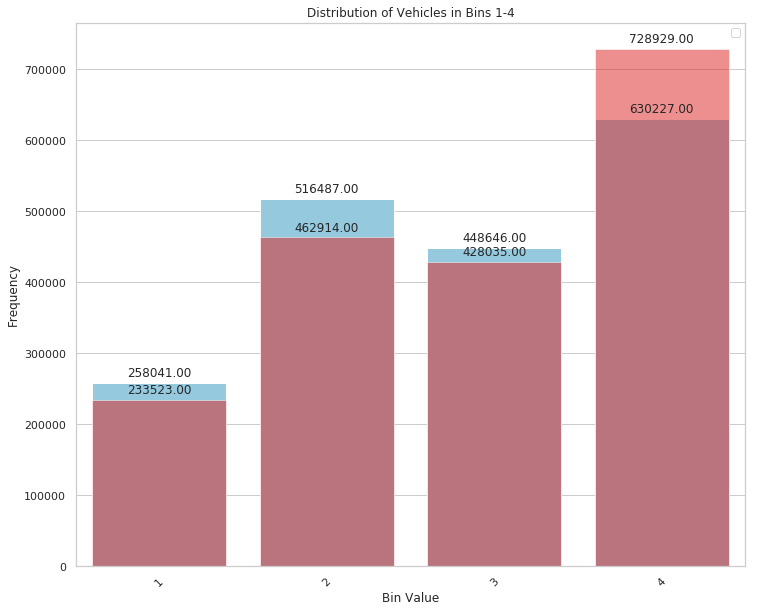

In [44]:
#Plot Bin distributions for each history length 
#set grid and font styles
sns.set(style="whitegrid")
#sns.set(font_scale=1.5)

#plot model year distribution 
size  = (12, 10)
fig, ax = plt.subplots(figsize = size)
plt.xticks(rotation=45)

sns.countplot(x="new_bin", data= df_o, color = 'skyblue')
sns.countplot(x="orig_bin", data= df_o, color = 'red', alpha = 0.5)

# Plot formatting
plt.xlabel('Bin Value')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Vehicles in Bins 1-4')

# control x and y limits
#plt.xlim(1980, 2018)
#ax.set(xlim=(1980, 2018))

#for i, v in enumerate(plots_df["crash_year"].iteritems()):        
#    ax.text(i ,v[1], "{:,}".format(v[1]), color='m', va ='bottom', 
#    rotation=45)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

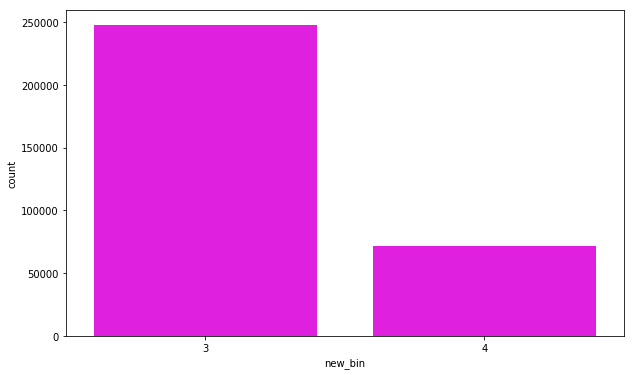

In [85]:
plt.figure(figsize=(10, 6))
sns.countplot(x="new_bin", data= dfb_full, color = 'skyblue')
sns.countplot(x="new_bin", data= dfb_400, color = 'magenta')
plt.show()

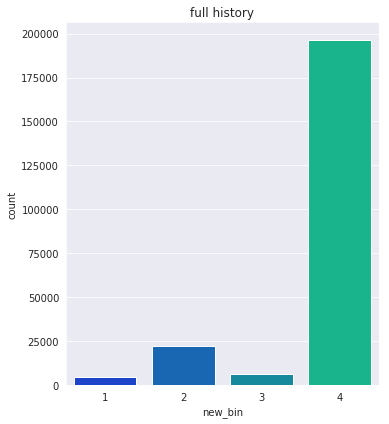

In [52]:
f = plt.figure(figsize=(10, 6))
gs = f.add_gridspec(1, 2)

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 0])
    sns.countplot(x="new_bin", data= dfb_full, palette="winter").set_title("full history")

#with sns.axes_style("darkgrid"):
#    ax = f.add_subplot(gs[0, 1])
#    sns.countplot(x="new_bin", data= dfb_400, palette="winter").set_title("400 trip history")

#with sns.axes_style("darkgrid"):
#    ax = f.add_subplot(gs[1, 0])
#    sns.countplot(x="new_bin", data= dfb_may, palette="winter").set_title("1 month history")
  
f.tight_layout()

/u/lguerra5/.conda/envs/py368nb/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Distribution of R2 value for recovered VINS')

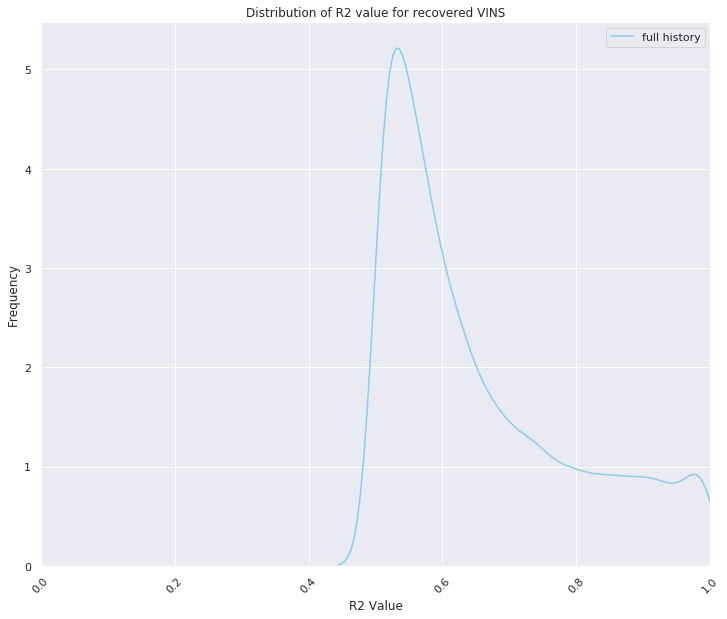

In [53]:
#plot histogram of R2 distribution
#set grid and font styles
sns.set(style="darkgrid")
#sns.set(font_scale=1.5)

#plot model year distribution 
size  = (12, 10)
fig, ax = plt.subplots(figsize = size)
plt.xticks(rotation=45)
# Method 1: on the same Axis
sns.distplot( dfb_full[(dfb_full['delta_bin']!=0)]["r_squared"], color="skyblue", hist = False, label="full history")
#sns.distplot( dfb_400[(dfb_400['delta_bin']!=0)]["r_squared"], color="red", hist=False, label="400 trip history")
#sns.distplot( dfb_may[(dfb_may['delta_bin']!=0)]["r_squared"], color="green", hist=False, label="1 month history")

# control x and y limits
plt.xlim(0, 1)
#ax.set(xlim=(1980, 2018))

# Plot formatting
plt.xlabel('R2 Value')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of R2 value for recovered VINS')

/u/lguerra5/.conda/envs/py368nb/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Distribution of R2 value for recovered VINS')

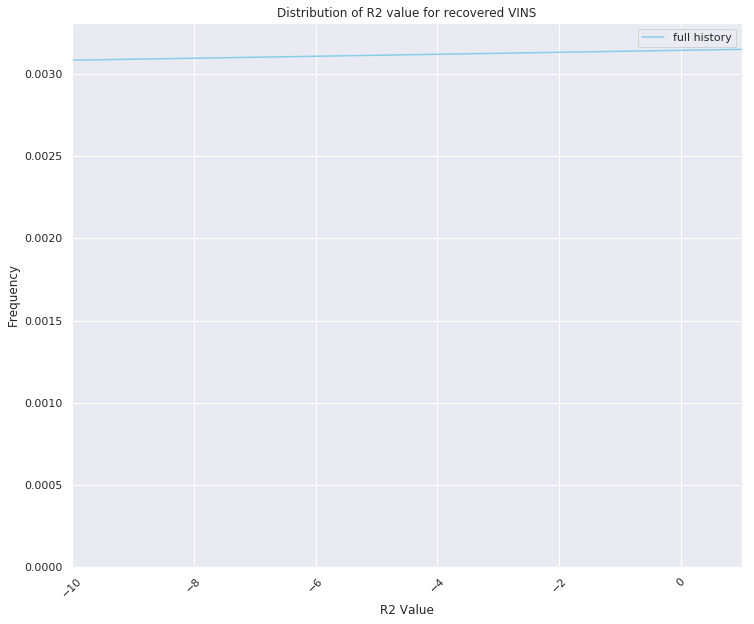

In [56]:
#plot histogram of R2 distribution - Unrecovered VINS
#set grid and font styles
sns.set(style="darkgrid")
#sns.set(font_scale=1.5)

#plot model year distribution 
size  = (12, 10)
fig, ax = plt.subplots(figsize = size)
plt.xticks(rotation=45)
# Method 1: on the same Axis
sns.distplot( dfb_full[(dfb_full['delta_bin']==0)]["r_squared"], color="skyblue", hist = False, label="full history")
#sns.distplot( dfb_400[(dfb_400['delta_bin']==0)]["r_squared"], color="red", hist=False, label="400 trip history")
#sns.distplot( dfb_may[(dfb_may['delta_bin']==0)]["r_squared"], color="green", hist=False, label="1 month history")

# control x and y limits
plt.xlim(-10, 1)
#ax.set(xlim=(1980, 2018))

# Plot formatting
plt.xlabel('R2 Value')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of R2 value for recovered VINS')

In [148]:
1500/2.9

517.2413793103449

In [149]:
400/2.9

137.93103448275863

In [152]:
517/30

17.233333333333334

In [153]:
138/30

4.6